## Plinko Simulation Project
#### Nathan Pacey

Plinko Record: https://www.youtube.com/watch?v=yKTBv7ZqFcU&ab_channel=EntertainmentTonight

The objective of this code is to model a Plinko drop with a varying coefficient of drag. This can be
done to compare the Plinko in air and “underwater”. 

## Import Necessary Libraries

In [1]:
import numpy as np
import math as m
from random import random
from matplotlib import pyplot as plt
%matplotlib inline
import random

### Functions to randomize initial conditions

In [2]:
# set the initial position of the ball to a random position between -0.2 and 0.2
def rand_initPos(x):
    x += random.uniform(-0.20,0.20)
    return x

# set the starting angle to a random value between 0.9(theta) and 1.1(theta) ****CHECK****
def rand_angle(theta):
    theta += random.uniform(-theta*0.10,theta*0.10)
    return theta

# set the x & y velocities to random values between 0(v) and 0.05(v)
def rand_absorption(x_vel, y_vel, theta):
    x_vel += random.uniform(0.00, 0.05)*abs(x_vel)*np.cos(theta)
    y_vel += random.uniform(0.00, 0.05)*abs(y_vel)* np.sin(theta)
    return x_vel, y_vel

#### Hypotenuse Function (for collision detection later)

In [3]:
# uses pythagorean th. to calculate hypotenuse of x & y vectors
def pythagorean(x_0, x1, y_0, y1):
    h = ((x_0-x1)**2 + (y_0-y1)**2)**0.5
    return h

#### Functions finding velocity and acceleration based on drag/gravitational forces

In [4]:
# calculates acceleration in the x-direction given a drag force
# no gravity in x-direction
def x_acceleration(x_vel, drag):
    
    if (x_vel < 0): # drag opposes velocity
        drag = -np.copy(drag)

    acceleration = -drag * x_vel**2 # calculate x-acceleration
    return acceleration


# calculate the acceleration in the y-direction given a drag force and gravity
def y_acceleration(y_vel, drag):
    gravity = 981 # acceleration due to gravity
    
    if (y_vel < 0): # drag opposes velocity
        drag = -np.copy(drag)
    
    acceleration = -gravity-drag * y_vel**2 # calculate y-acceleration
    return acceleration

# updates incoming x & y velocities based on calculated x & y accelerations
def velocity(x_vel1, y_vel1, drag, del_t):
    # calculate new x & y velocities
    x_vel2 = x_vel1 + x_acceleration(x_vel1, drag)*del_t
    y_vel2 = y_vel1 + y_acceleration(y_vel1, drag)*del_t

    # returns refracted velocities
    return x_vel2, y_vel2

### Setting Up the Plinko Container

In [5]:
# initializes variables to be plotted
def plotVars():
    xpts = np.arange(0, 101, 10) # 10 x-points from 0 -> 100

    half_xpts = np.arange(5, 100, 10)
    
    y = np.arange(0, 80, 10*np.sin(np.pi/3)) # set up y-points with sine function

    y_flipped = np.flip(y) # flip y elements
    
    return xpts, half_xpts, y_flipped

# plot the Plinko board
def plot_board(plot):
    xpts, half_xpts, y_flipped = plotVars() # initialize variables
    
    if plot == 1:
        # plot pegs
        plt.figure(figsize=(30,30))
        plt.xlim(0, 100)
        plt.ylim(-5, 100) # y-limit allows last peg to show
    
        plt.title ("Plinko Game!", fontsize = 50)
        plt.xlabel("X-Axis", fontsize = 40)
        plt.ylabel("Y-Axis", fontsize = 40)
    
        plt.xticks(np.arange(0, 101, 10))  # ticks match the bins
        plt.yticks(np.arange(0, 101, 10))
        plt.xticks(fontsize = 25)
        plt.yticks(fontsize = 25)
    
        for j in range (10):
            if (j%2 == 1):
                y_peg = y_flipped[j] * np.ones(np.size(half_xpts))
                plt.scatter(half_xpts, y_peg, marker = 'o', color = 'cornflowerblue', s = 1500, label = 'Pegs')
            
            if (j%2 == 0):
                y_peg = y_flipped[j] * np.ones(np.size(xpts))
                plt.scatter(xpts, y_peg, marker = 'o', color = 'cornflowerblue', s = 1500, label = 'Pegs')
            
    return half_xpts, xpts, y_flipped # return arrays


#plot_board(1) # test the configuration is accurate
    


### Plotting the Ball Movement

In [6]:
# plotting the trajectory of the ball
def plot_ball(x, y, collisions):
    
    # indices of impact points correspond to position at each impact
    xCollision  = []
    yCollision = []
    
    for col in collisions: # separate x and y collisions
        xCollision = np.append(xCollision, x[col])
        yCollision = np.append(yCollision, y[col])
        
    # plot the path of the ball
    plt.plot(x, y, 'ro', ms = 10)
    # add points of collision to plot
    plt.plot(xCollision, yCollision, 'co', ms = 20, label = 'Collisions')

    plt.legend(["Ball Motion", "Collisions", "Pegs"], prop={'size': 30})    
    plt.show()

## Now, to deal with collisions:

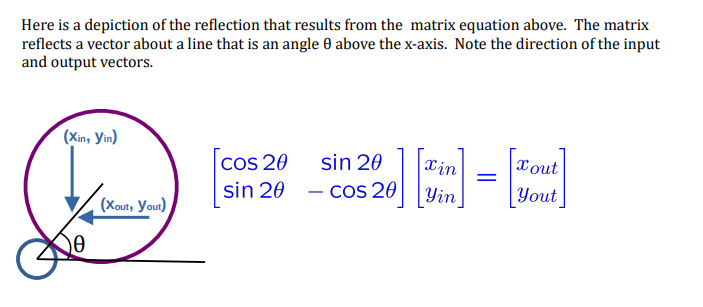

### How the Ball Moves

In [7]:
# radiii of objects [cm]
r_ball = 2.5
r_pegs = 0.5

# first need a function to define the bounce of the ball off the pegs
# returns the velocity of the ball
def peg_bounce(x_vel, y_vel, x_ball, x_peg, y_ball, y_peg):

    # determine angle of strike
    if (x_ball != x_peg):
        angleIn = np.arctan((y_ball - y_peg)/(x_ball - x_peg))
    else:
        # if ball strikes vertically set angle to pi/2 to avoid division by zero
        angleIn = np.pi/2
    
    # random reflected angle
    angleOut = rand_angle(angleIn)
    
    # x & y velocities found with deflection equations
    x_vel2 = -(np.cos(2*angleOut)*x_vel + y_vel * np.sin(2*angleOut))
    
    y_vel2 = -(np.sin(2*angleOut)*x_vel - y_vel * np.cos(2*angleOut))
    
    # adjust the velocity to account for a random absorption
    x_vel, y_vel = rand_absorption(x_vel2, y_vel2, angleOut)
    
    return x_vel, y_vel, 1 # 1 indicates a collision, 0 means no collision

### Detecting Collisions

In [8]:
## ** detecting collisions and setting the collision velocities **

def collision_dect (collision, x_vel, y_vel, x_ball, y_ball, yArray, half_xpts, xpts):
    
    # function dependent on the collisions conditional
    if collision == 0:
        closest_y = 0
        
        for j in range(10): # find the vertical y, closest value
            if abs(y_ball-yArray[j]) < abs(y_ball-yArray[closest_y]):
                closest_y = np.copy(j)
  
        # if the ball is in the vertical range of the pegs test the horizontal range
        if (r_ball + r_pegs)>= abs(y_ball - yArray[closest_y]):
            closest_x = 0
            
            if closest_y%2 == 1: # now find the closest x value for the right peg

                for i in range(9): # update the x-values
                    if abs(x_ball-half_xpts[i+1]) < abs(x_ball-half_xpts[closest_x]):
                        closest_x = np.copy(i+1)
                        
                # return the hypotenuse of the new velocity vector
                radii = pythagorean(x_ball, half_xpts[closest_x], y_ball, yArray[closest_y])
                
                if radii <= (r_ball + r_pegs): # call the bounce method when the ball meets the collision condition
                    return peg_bounce(x_vel, y_vel, x_ball, half_xpts[closest_x], y_ball, yArray[closest_y])

            if closest_y%2 == 0: # given the right row, determine the close x value
                for i in range(1, 11):
                    # update the x array
                    if abs(x_ball-xpts[i]) < abs(x_ball-xpts[closest_x]):
                        closest_x = np.copy(i)
                        
                # return the hypotenuse of the new velocity vector
                radii = pythagorean(x_ball, xpts[closest_x], y_ball, yArray[closest_y])
                
                if radii <= (r_ball + r_pegs): # call the bounce method when the ball meets the collision condition
                    return peg_bounce(x_vel, y_vel, x_ball, xpts[closest_x], y_ball, yArray[closest_y])
                
    return x_vel, y_vel, 0 # 1 indicates a collision, 0 means no collision


## Plotting Functions

In [9]:
# x-position vs. y-position
def x_yPlot(x,y):
    plt.plot(x,y,"r")
    plt.title("X and Y Positions")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# position vs. time
def position_timePlot(initialX, x, y, time, plot):
    t = np.arange(0, x.size*0.001, 0.001)
    if plot == 1: # only plot if passed a 1 by user
        plt.plot(t, x, label = 'X Position')
        plt.plot(t, y, label = 'Y Position')
        plt.xlabel("Time")
        plt.ylabel("Position")
        plt.title('Position over Time')
        plt.legend(bbox_to_anchor=(1.0, 0.5))
        plt.show()
    # reset distance for each new position
    xdist = 0
    ydist = 0
    
    # need distance between current and last points in x and y directions
    for i in range (1,len(x)):
        xdist += abs(x[i]-x[i-1])
    for i in range (1,len(y)):
        ydist += abs(y[i]-y[i-1])
        
    if plot ==1:
        print("Total x distance", xdist)
        print("Total y distance", ydist)
    # returns total distances travelled in x and y directions
    return xdist, ydist

# velocity vs. time
def velocity_time(time, x_vel,y_vel,x):
    time = np.arange(0, x.size*0.001, 0.001)
    plt.plot(time, y_vel, label = 'Y Velocity')
    plt.plot(time, x_vel, label = 'X Velocity')
    plt.title('vy vs t (blue) and vx vs t (orange)')
    plt.xlabel("Time")
    plt.ylabel("Velocity Value")
    plt.legend(bbox_to_anchor=(1.0, 0.5))
    plt.show()


    
# *****Freq transformation to find the max ********    

def BouncingFreq_Plot(y_vel, plot):

    Vyk = np.fft.fft(y_vel)[1:-1]
    Vyk = abs(Vyk)
    Max_freq = np.argmax(Vyk[0:210])
    freq = np.arange(0, 210)
    
    if plot == 1:
        plt.plot(freq, (Vyk)[0:210])
        plt.title('Frequency of change of Direction')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Absolute value of bouncing Frequency")
        plt.show()
        
        print("The maximum bouncing frequency is",Vyk[Max_freq],"and occurs at",Max_freq,"Hz")

    area = np.sum(Vyk[0:150])
    
    if plot == 1:
        print("\nThe integrated area of frequency from 0 Hz to 150 Hz is", area)

    # returns the maximum bouncing frequency and the area under the plot
    return Vyk[Max_freq], area

## The Final Plinko Simulation

In [10]:
def Plinko(initialX, time, drag, plot):
    # declare constants
    del_t = 0.001
    Num = int(time/del_t) #determine the number of points
    
    initialY = 90     # set the initial positions and velocities
    initialX_Vel = 0 
    initialY_Vel = 0

    xVel = np.ones(Num) * rand_initPos(initialX_Vel)
    yVel = np.ones(Num) * rand_initPos(initialY_Vel)
    
    # determine all the arrays for position and velocity
    x = np.ones(Num) * rand_initPos(initialX)
    y = np.ones(Num) * rand_initPos(initialY)
    
    # initialize the collisions array with a zero condition (miss condition)
    collisions = []
    Collision = 0

    # create the Plinko Board
    half_xpts, xpts, yArray = plot_board(plot) # call the plotting function
    
    for i in range (1, Num): # for every point in the x,y arrays determine if a collision occurs and output the properties ie velocities

        newX_Vel, newY_Vel, Collision = collision_dect (Collision, xVel[i-1], yVel[i-1], x[i-1], y[i-1], yArray, half_xpts, xpts)
        
        if Collision == 1:  # add collisions to collision array
            collisions = np.append(collisions, int(i))

        # determine the positions and velocities given a collision
        y[i] = newY_Vel*del_t+ y[i-1]
        x[i] = newX_Vel*del_t+ x[i-1] #calculate positions
        
        xVel[i], yVel[i] = velocity(newX_Vel, newY_Vel, drag, del_t) # calculate new velocities

        # ball wraps around the boundaries when it meets the walls
        if x[i] <= 0:
            x[i] = (x[i] + 100) # set an x at 0 to 100
            
        if x[i] >= 100:
            x[i] = (x[i] - 100) # set an x at 100 to 0        
                
        if y[i] <= 0:   # simulation ends when y <= 0, set the arrays to the appropriate size
            x = x[0:i]  # by splicing up to the last y index length
            y = y[0:i]
            xVel = xVel[0:i]
            yVel = yVel[0:i]
            
            collisions = collisions.astype(int) # set the collisions var to an int
            break
    
    Bin = m.floor((x[-1] + 5)/10) # x-position of final bin
    if Bin == 10: # wrap the last bin to the 0th bin
        Bin = 0
    
    time = x.size*0.001 # update the time
    
    if plot==1:
        plot_ball(x, y, collisions) # plot the path of the ball
        x_yPlot(x,y) # plot the x position vs. y position
        velocity_time(time, xVel,yVel,x) # plot the velocity vs. time
        print("Plinko!!\n\nThe Ball Landed in Bin",Bin, "With a final x position:",x[-1]) # test print
    
        print("The Simulation took", time ,"s to reach a y 0f 0") # display the total time
        
    xdist, ydist = position_timePlot(initialX, x, y, time, plot) # plot the position vs. time
    
    # ****** calling the freq plotting function *****
    Maxfreq, area = BouncingFreq_Plot(yVel, plot) # plot the bouncing frequency over time

    return Bin, x, y, xVel, yVel, collisions, time, xdist, ydist, Maxfreq, area



### Running the simulation many times and Histogram Data
Histogram of many runs for the time to reach y = 0

◦ Histogram of many runs for the total distance travelled

◦ Histogram of many runs for the bin the disc landed in.

◦ Histogram of many runs for the frequency of the maximum occurrence of bouncing

◦ Histogram of many runs for the integrated area of the frequency of bouncing (from 0-
150 Hz)

In [11]:
#making many times 10 because my computer cannot run the program more than 10 times in 5 minutes
many = 100
initialX = 50
drag = 0.01

def manyRuns(drag,many,initialX):
    time = 5
    BinsT = np.zeros(many)
    timeT = np.zeros(many)
    xdistT = np.zeros(many) 
    ydistT = np.zeros(many)
    Max_freq = np.zeros(many)
    area = np.zeros(many)

    for i in range(many):
        BinsT[i], xT, yT, x_velT, y_velT, collisionsT,timeT[i], xdistT[i], ydistT[i], Max_freq[i], area[i] = Plinko(initialX, time,drag, 0)
    
    return BinsT, timeT, xdistT, ydistT, Max_freq, area
    

BinsT, timeT, xdistT, ydistT, Max_freq, area = manyRuns(drag,many, initialX)

#### Histogram Functions

In [12]:
# time for the ball to reach the bottom
def Hist_time(time):
    plt.hist(time, bins = 'auto', label = "time" )
    plt.title("Total Time to Reach y = 0")
    plt.xlabel("Time (s)")
    plt.ylabel("Bins")
    plt.show()

# total x-distance travelled
def Hist_disX(xdistT):
    plt.hist(xdistT, bins = 'auto', label = "X-Distance", color = (random.random(),random.random(),random.random()))
    plt.title("Total X-Distance Travelled")
    plt.xlabel("x-Distance")
    plt.ylabel("Bins")
    plt.show()

def Hist_disY(ydistT):
    plt.hist(ydistT, bins = 'auto', label = "Y-Distance", color = (random.random(),random.random(),random.random()))
    plt.title("Total Y-Distance")
    plt.xlabel("Y-Distance")
    plt.ylabel("Bins")
    plt.show()
    
def Hist_bins(BinsT):
    plt.hist(BinsT, bins = 'auto', label = "Bins", color = (random.random(),random.random(),random.random()))
    plt.title("Bins that were Landed In")
    plt.xlabel("Bins Landed In")
    plt.ylabel("Bins")
    plt.show()

def Hist_freq(Max_freq):
    plt.hist(Max_freq, bins = 'auto', label = "Max Freq.", color = (random.random(),random.random(),random.random()))
    plt.title("Maximum Frequency")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Bins")
    plt.show()
    
def Hist_freqArea(area):
    plt.hist(area, bins = 'auto', label = "area", color = (random.random(),random.random(),random.random()))
    plt.title("Area Under Maximum Frequency Plot")
    plt.xlabel("Area [Hz]")
    plt.ylabel("Bins")
    plt.show()
    

def initializeHist(BinsT, timeT, xdistT, ydistT, Max_freq, area): 
    Hist_time(timeT)
    Hist_disX(xdistT)
    Hist_disY(ydistT)
    Hist_bins(BinsT)
    Hist_freq(Max_freq)
    Hist_freqArea(area)

## Simulation With Drag = 0.01

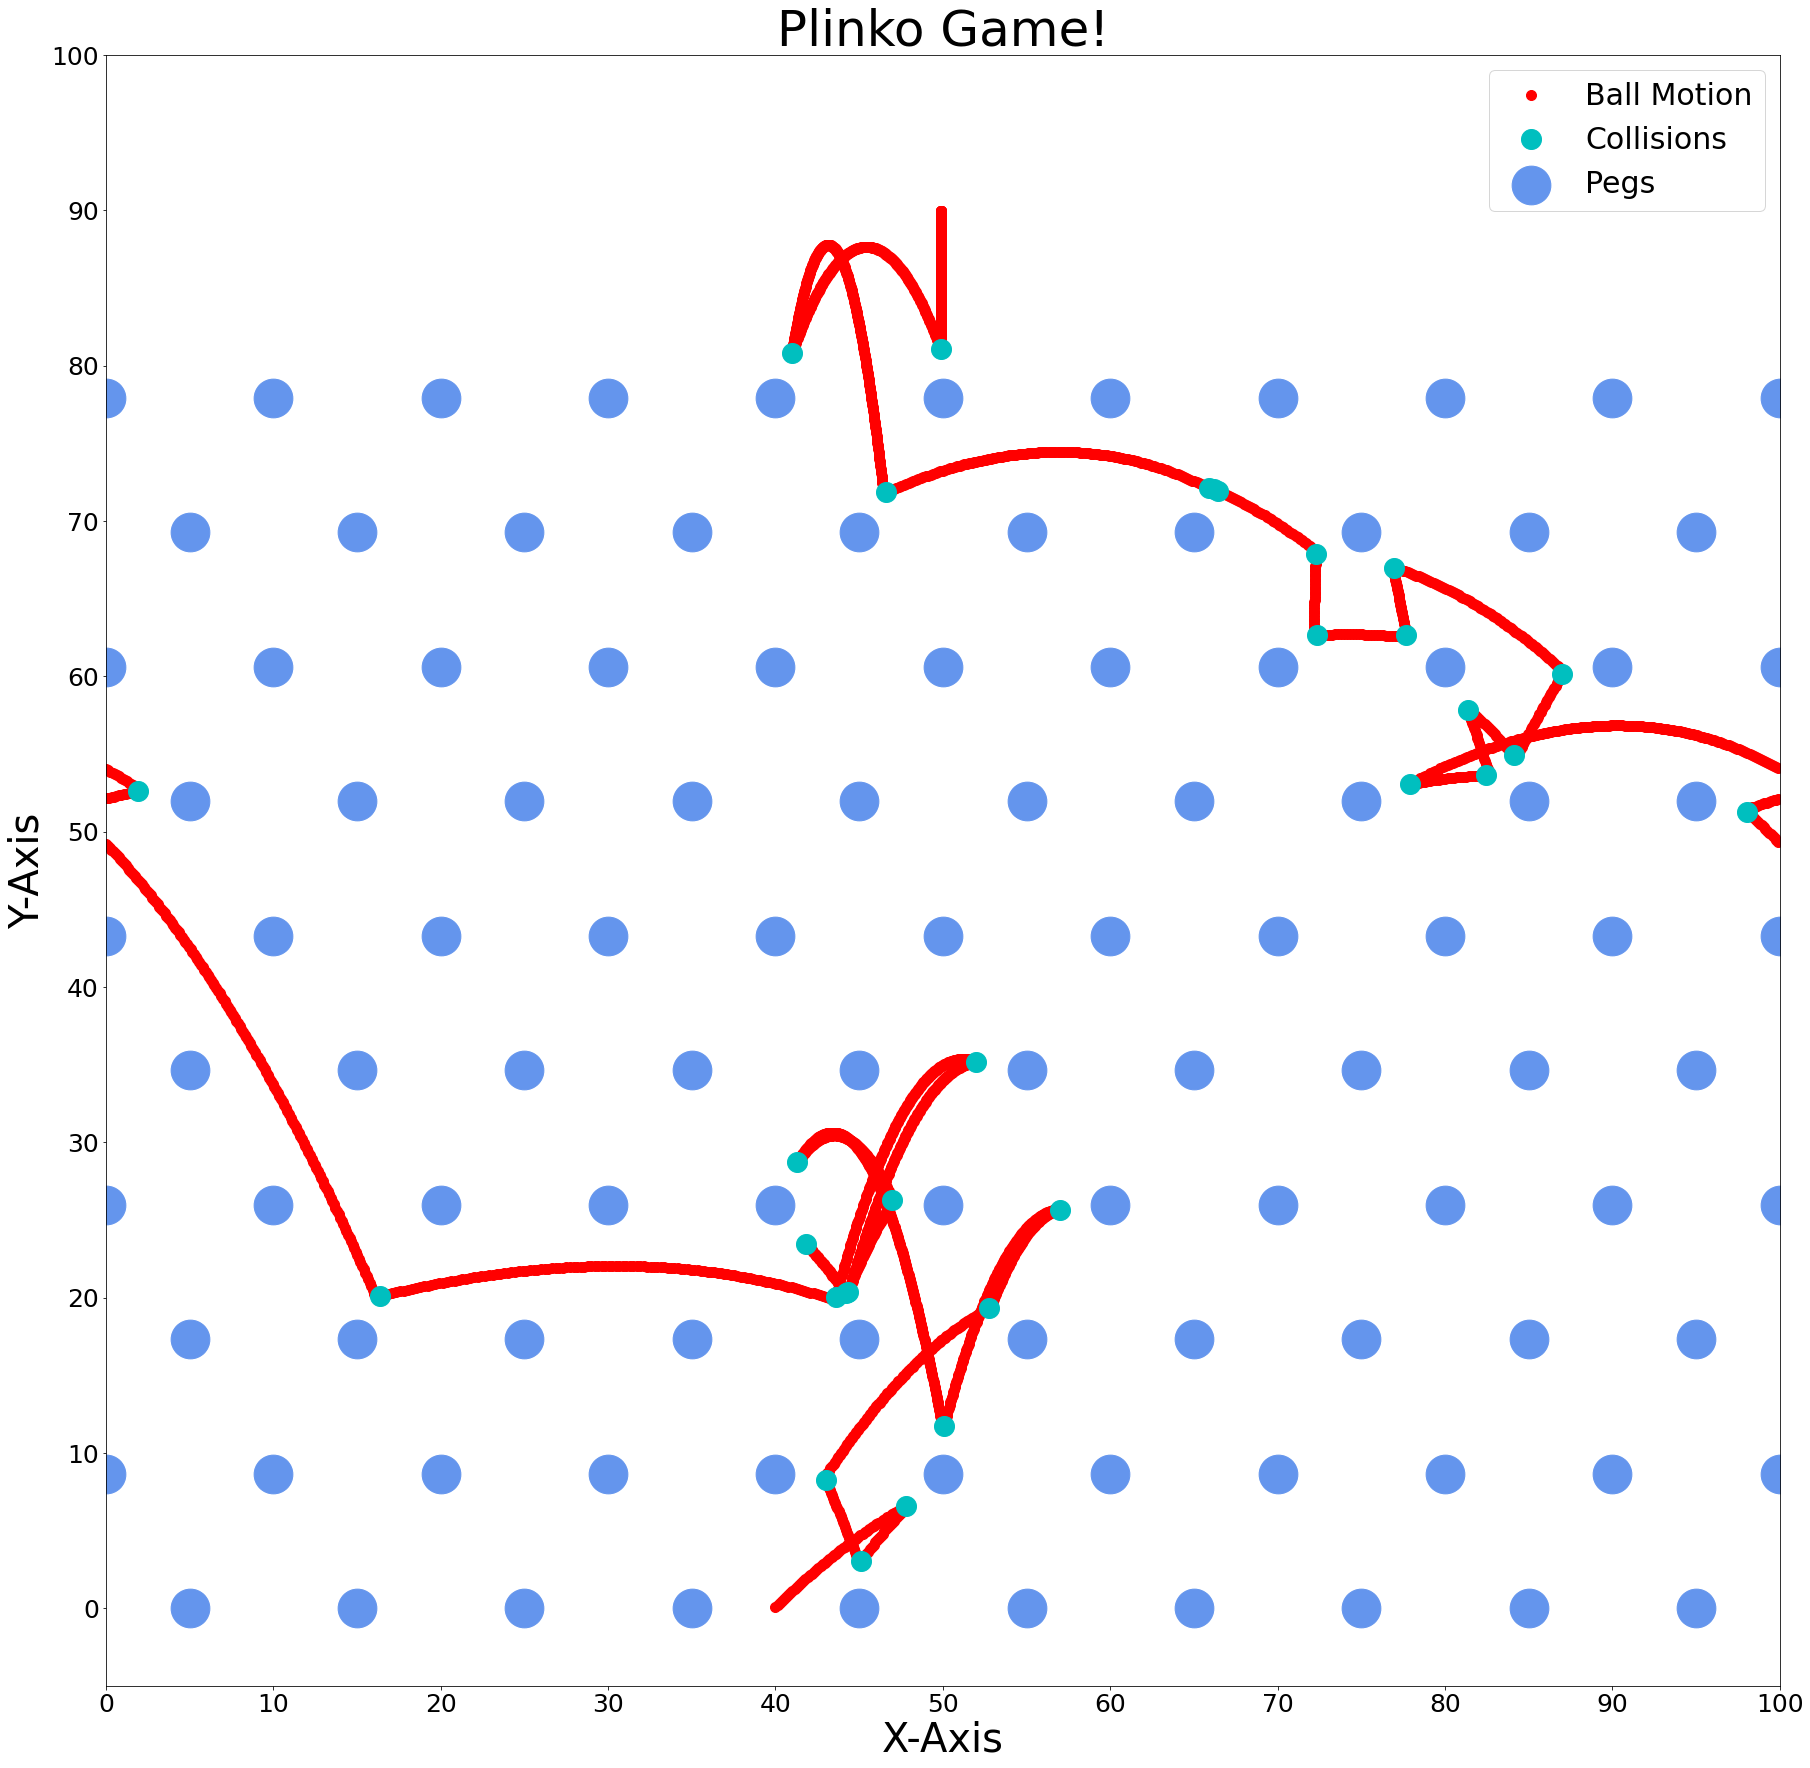

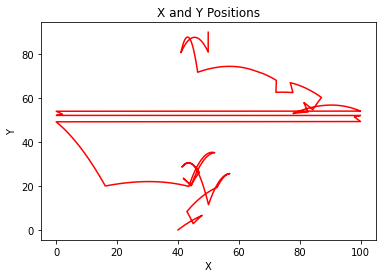

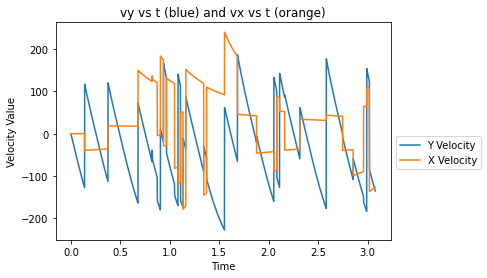

Plinko!!

The Ball Landed in Bin 4 With a final x position: 39.999780300984625
The Simulation took 3.078 s to reach a y 0f 0


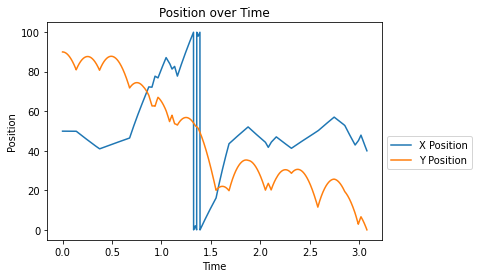

Total x distance 515.0547833700521
Total y distance 248.1974231914832


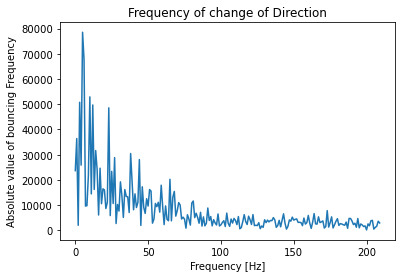

The maximum bouncing frequency is 78533.97933887936 and occurs at 5 Hz

The integrated area of frequency from 0 Hz to 150 Hz is 1518284.8109056423


In [13]:
# setting the simulation conditions to pass to the function
initialX = 50
drag = 0.01
time = 5

Bins, x, y, x_vel, y_vel, collisions,time, xdist, ydist, Maxfreq, area = Plinko(initialX, time,drag,1)
BinsT, timeT, xdistT, ydistT, Max_freq, area = manyRuns(drag,many, initialX)


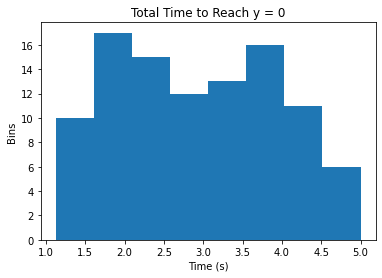

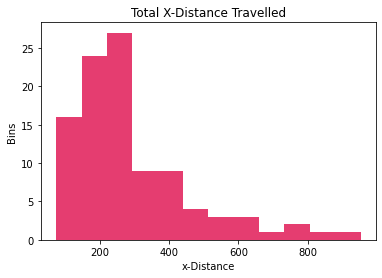

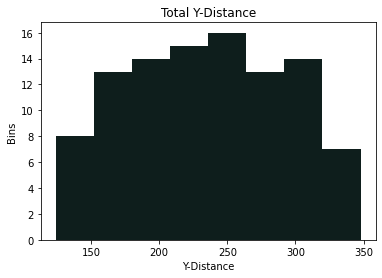

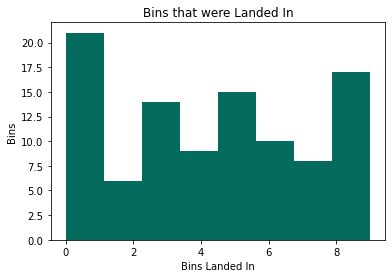

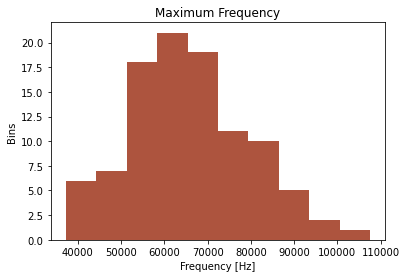

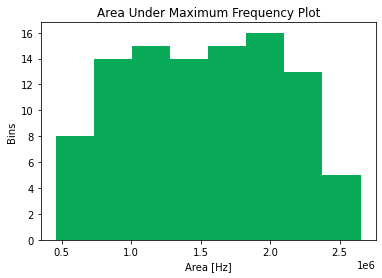

In [14]:
# output all plots
initializeHist(BinsT, timeT, xdistT, ydistT, Max_freq, area)

## Simulation With drag = 0.5

Simulation with drag = 0.5


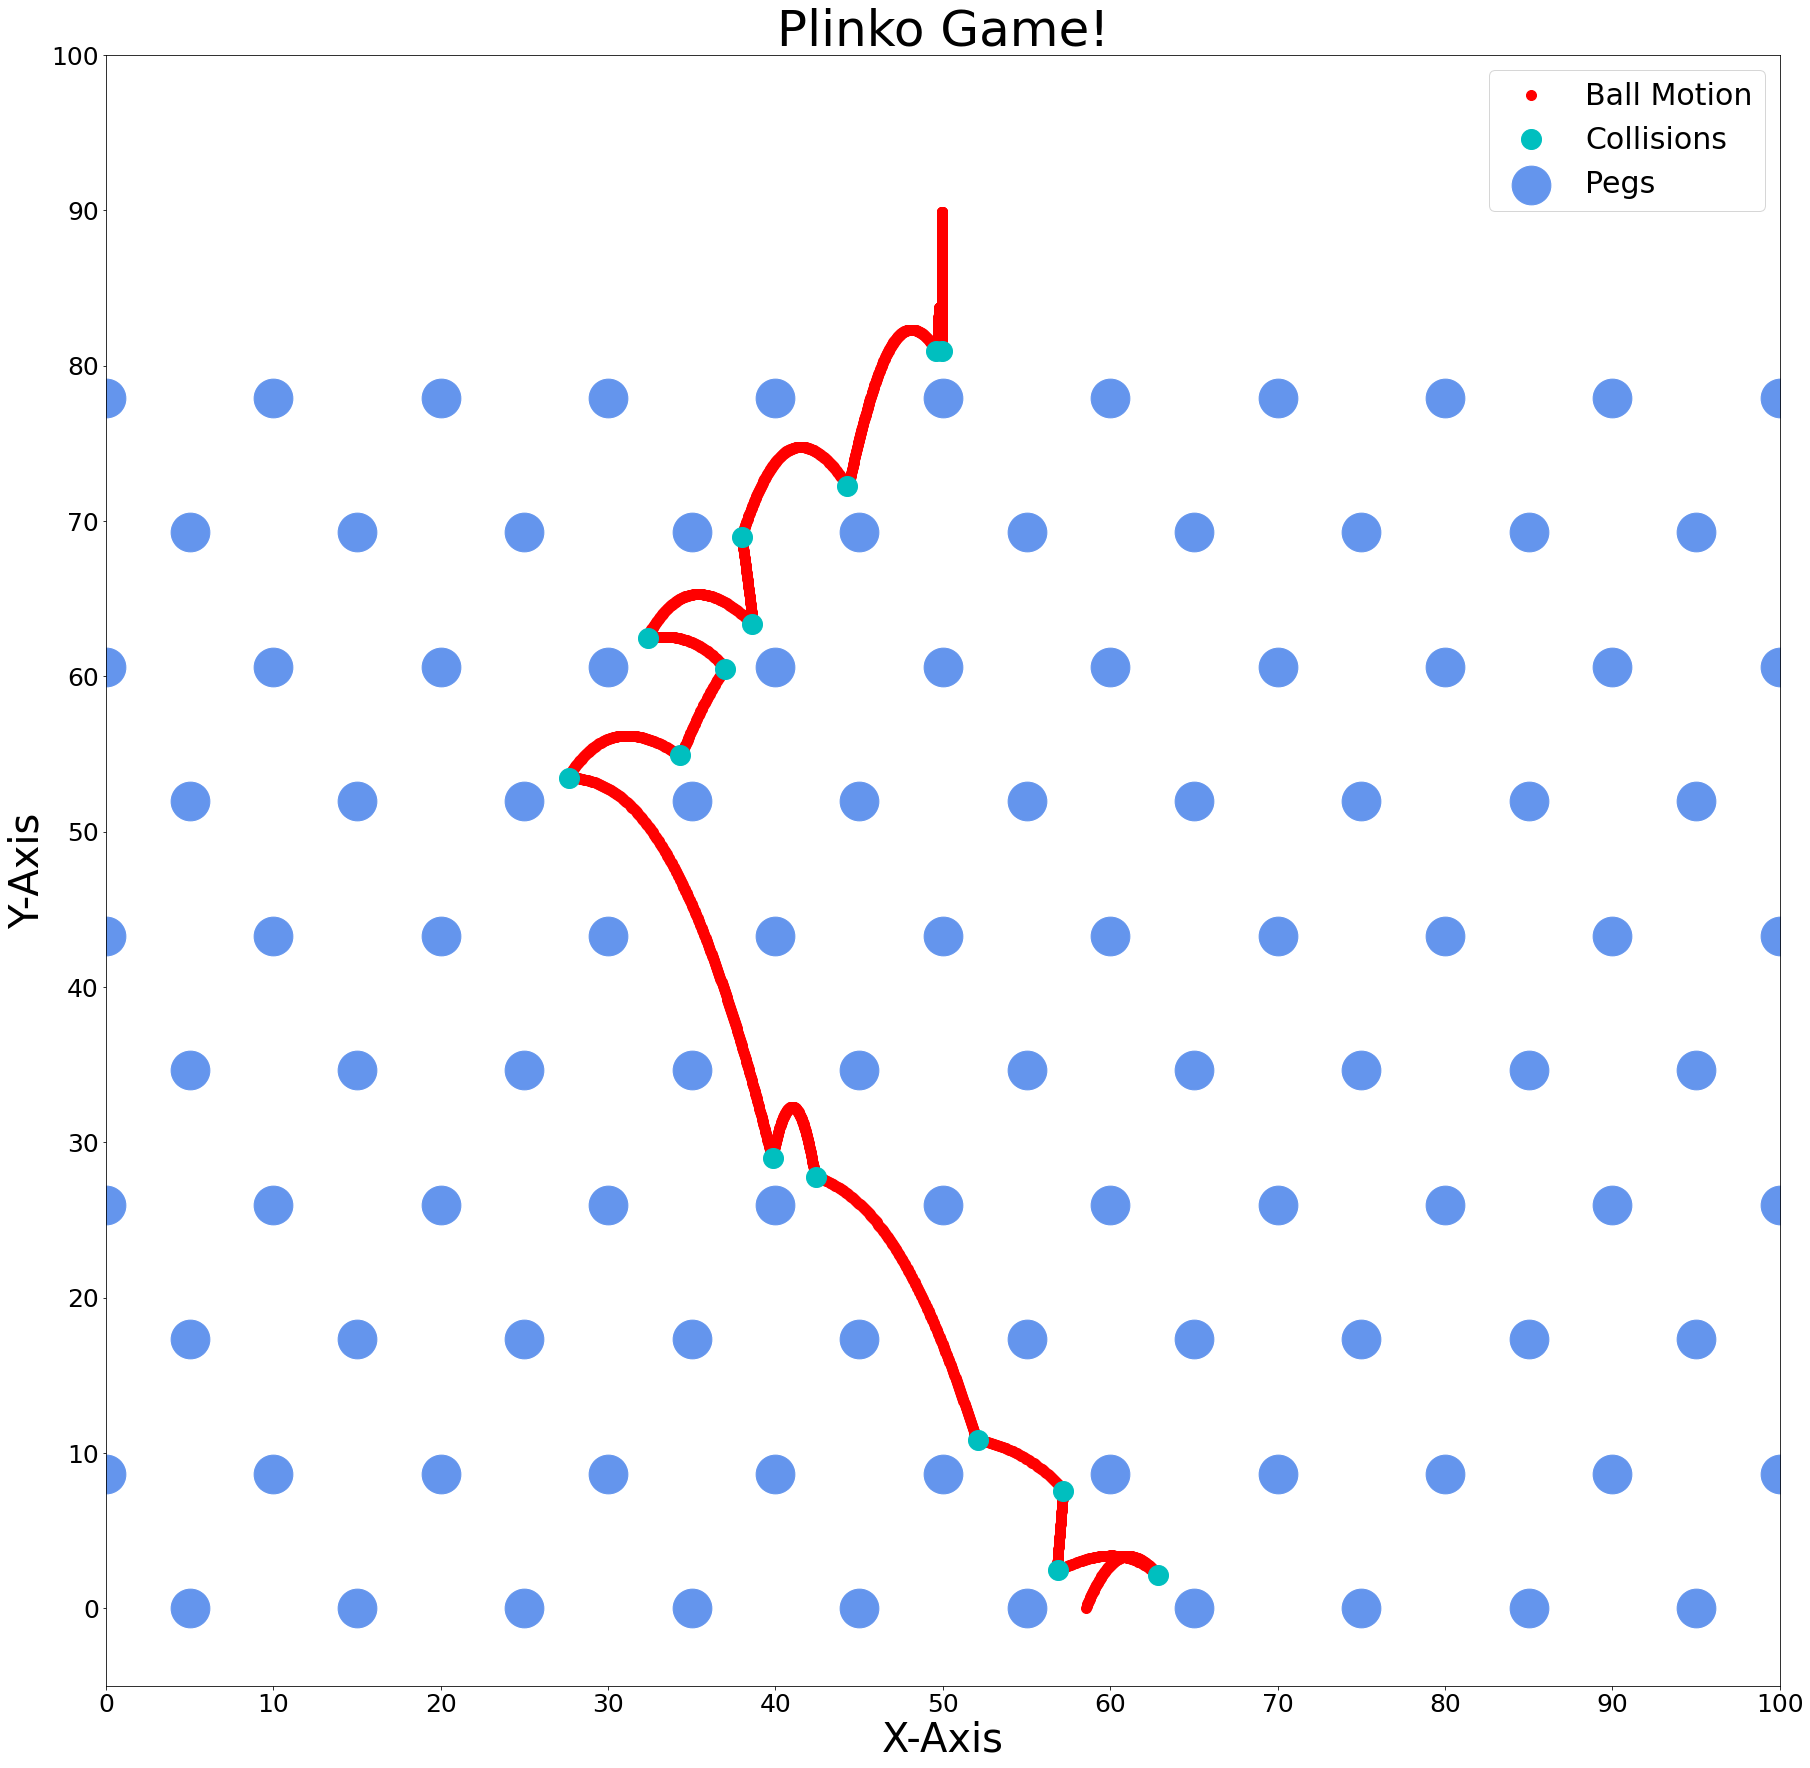

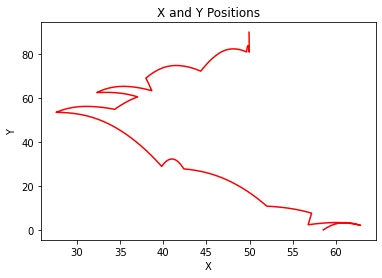

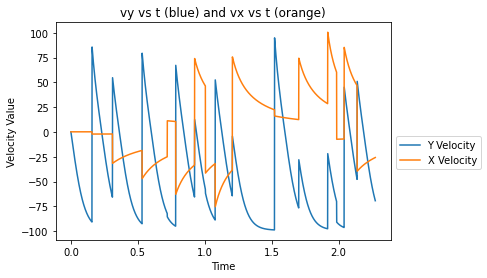

Plinko!!

The Ball Landed in Bin 6 With a final x position: 58.558289531495134
The Simulation took 2.274 s to reach a y 0f 0


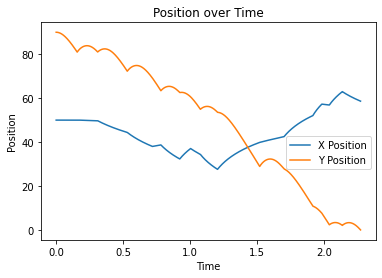

Total x distance 73.69418861395643
Total y distance 121.71705239989409


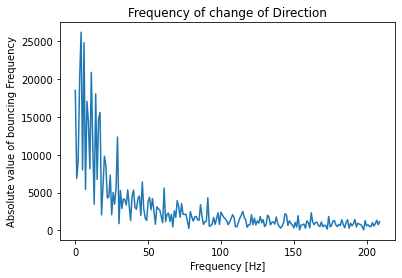

The maximum bouncing frequency is 26151.476553834127 and occurs at 4 Hz

The integrated area of frequency from 0 Hz to 150 Hz is 556345.3427602807


In [15]:
# setting the simulation conditions to pass to the function
initialX = 50
drag = 0.1
time = 5
print("Simulation with drag = 0.5")

Bins, x, y, x_vel, y_vel, collisions, time, xdist, ydist, Max_freq, area = Plinko(initialX, time,drag,1)
BinsT, timeT, xdistT, ydistT, Max_freq, area = manyRuns(drag,many, initialX)


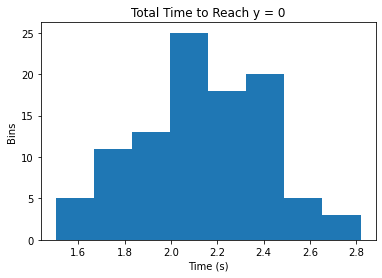

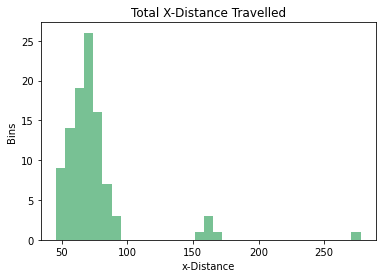

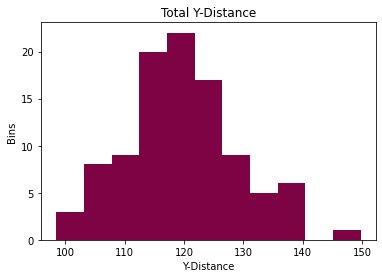

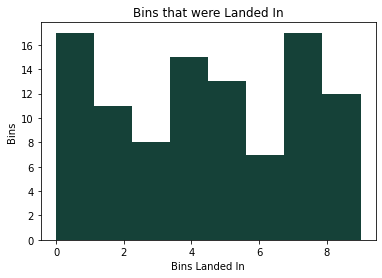

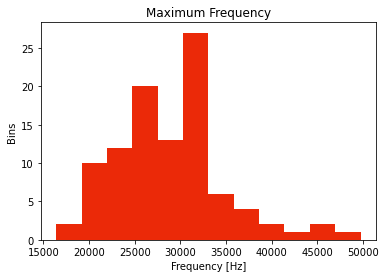

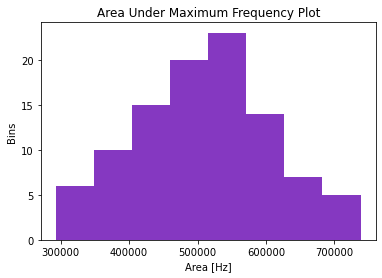

In [16]:
initializeHist(BinsT, timeT, xdistT, ydistT, Max_freq, area)

## What changing the drag coefficient does

When comparing the drag coefficients here are some of the significant differences:
- the lower the drag the more time it takes for the ball to reach y = 0, since the ball encounters more collisions
- the lower the drag the more x and y distance travelled. For 0.01 drag the average x and y distance was about 200 and 225, while for the 0.5 drag the x distance was 75 while the y distance was 120.
- The frequency is also much higher for a lower drag coefficient; from a maximum frequency of 65000 Hz (drag 0.01) to only 27500 Hz (drag 0.5)
- The lower frequency also decreases the area under the frequency curve


# Testing the Simulation by changing the initial position

Changing the initial position to 75 in x


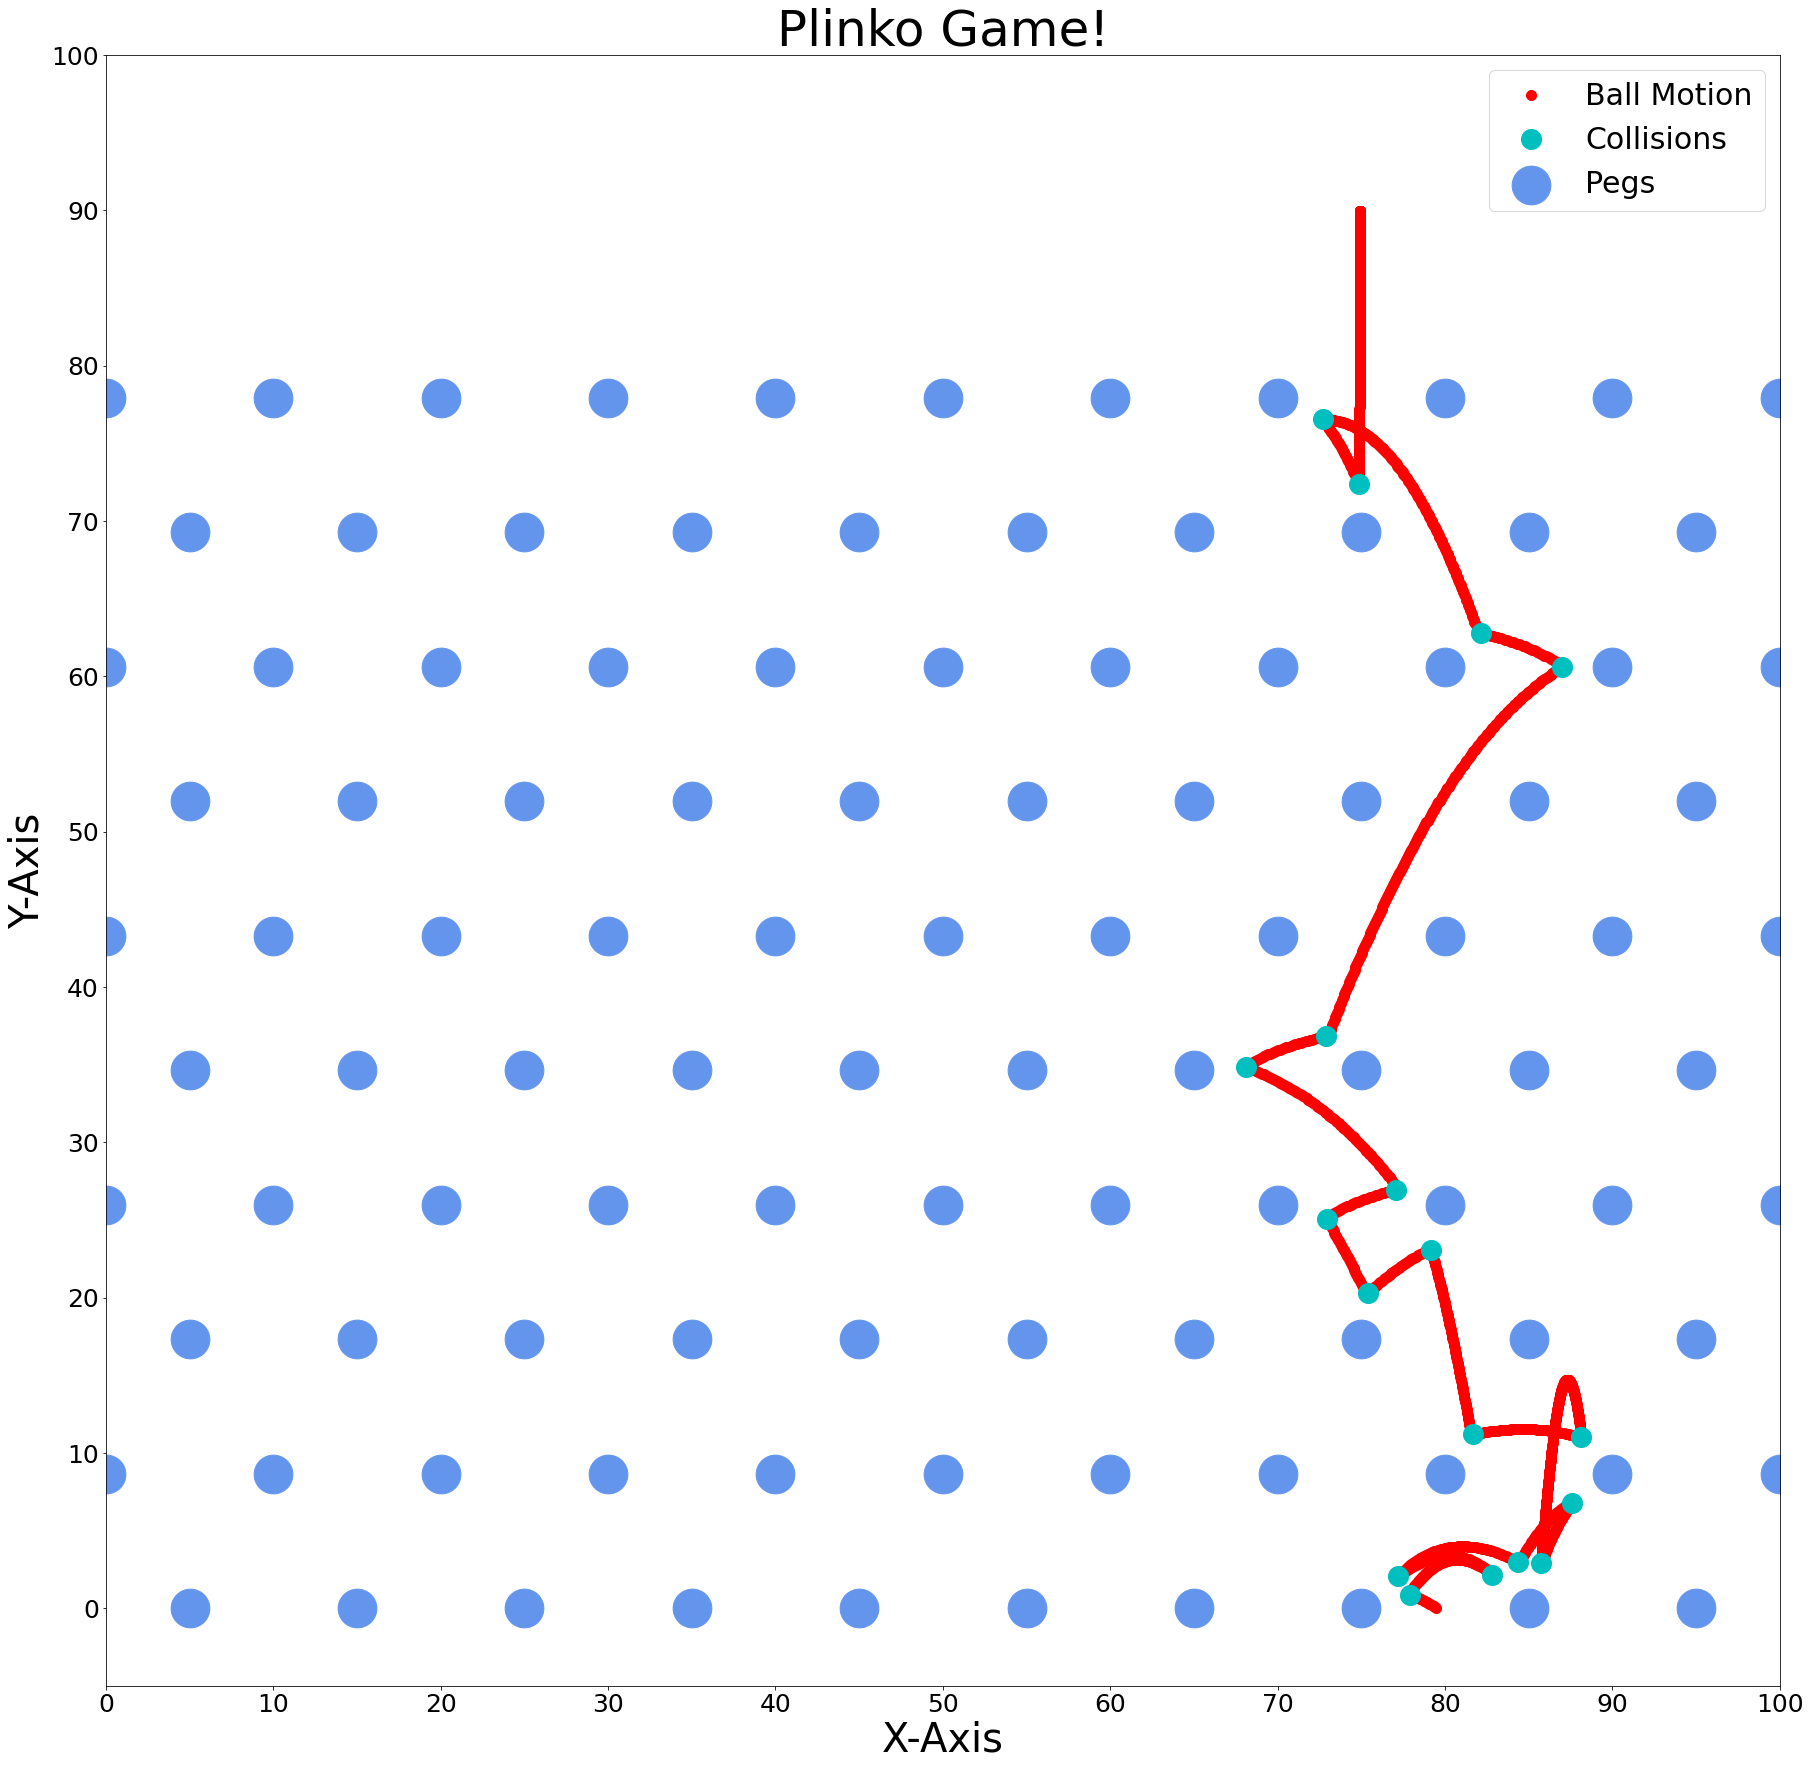

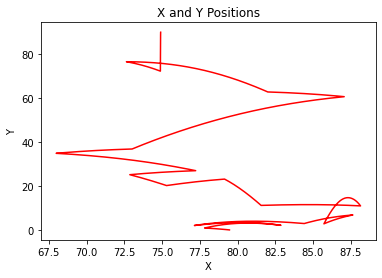

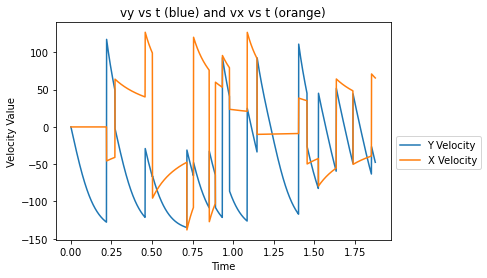

Plinko!!

The Ball Landed in Bin 8 With a final x position: 79.46267938575507
The Simulation took 1.877 s to reach a y 0f 0


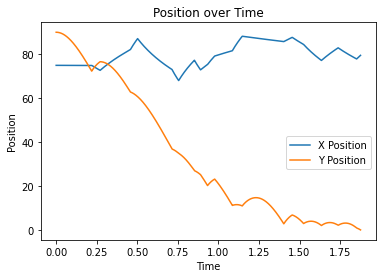

Total x distance 91.94093842639425
Total y distance 127.44724018165617


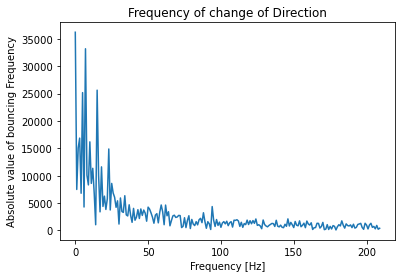

The maximum bouncing frequency is 36213.66838914706 and occurs at 0 Hz

The integrated area of frequency from 0 Hz to 150 Hz is 556006.0979892956


In [17]:
# setting the simulation conditions to pass to the function
initialX = 75 # changing the starting x position to 75
drag = 0.05  #setting the drag back to 0.05
time = 5
print("Changing the initial position to 75 in x")
Bins, x, y, x_vel, y_vel, collisions, time, xdist, ydist, Max_freq, area = Plinko(initialX, time,drag,1)

## Animating the Plinko Simulation¶

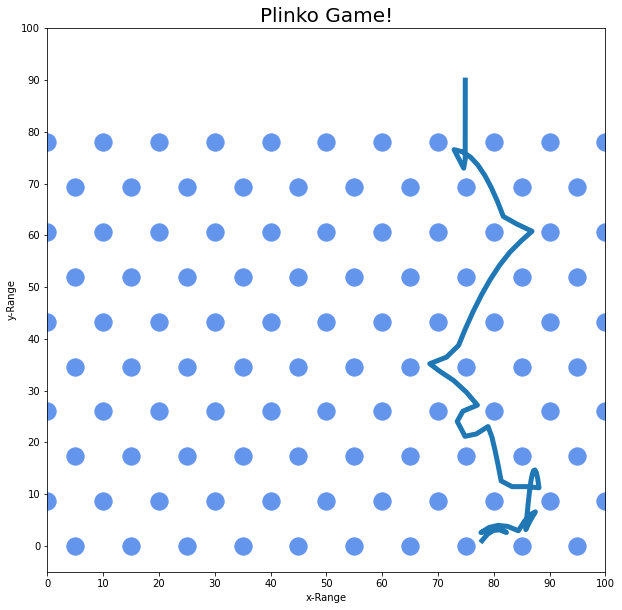

In [18]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rcParams

#rcParams['animation.ffmpeg_path']='/usr/bin/ffmpeg'

rcParams['animation.embed_limit'] = 2**128

xp, half_xp, y_f = plotVars()

fg = plt.figure(figsize=(10,10))
ax = plt.axes(xlim=(0, 100),ylim=(-5, 100))

plt.title ("Plinko Game!", fontsize = 20)
plt.xlabel("x-Range", fontsize = 10)
plt.ylabel("y-Range", fontsize = 10)

plt.xticks(np.arange(0, 101, 10))  # ticks match the bins
plt.yticks(np.arange(0, 101, 10))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

for j in range (10):
    if (j%2 == 1):
        yP = y_f[j] * np.ones(len(half_xp))
        plt.scatter(half_xp, yP, marker = 'o', color = 'cornflowerblue', s = 300, label = 'Pegs')

    if (j%2 == 0):
        yP = y_f[j] * np.ones(len(xp))
        plt.scatter(xp, yP, marker = 'o', color = 'cornflowerblue', s = 300, label = 'Pegs')


line, = plt.plot([], [], lw=5)

def init():
    line.set_data([], [])
    return (line,)

xa, ya =[], []
xx = np.array(x[0::25])
yy = np.array(y[0::25])


xy = np.zeros([len(xx), len(xx)])
for i in range(len(xx)):
    xy[0, i] = xx[i]
    for j in range(len(xx)):
        xy[i, j] = yy[i]

def ann(i):
    xp = np.linspace(0, 100)
    line.set_data(xp[:i], xy[i, :i])
    return line
def an(i):
    #xa.append(x[i])
    #ya.append([y[i])
    #line.set_data(xa, ya)
    line.set_data(xx[:i], yy[:i])
    return (line,)

anim = FuncAnimation(fg, an, init_func=init, frames=len(xx), blit=True)

#HTML(anim.to_html5_video())
HTML(anim.to_jshtml())
#anim